In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest
from mapper import Mapper

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [4]:
sess = tf.InteractiveSession()

In [5]:
n_components_in_mixture = 4
n_sources = 2

In [6]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=500, n_components_in_mixture=n_components_in_mixture, n_features=2, n_sources=n_sources, mixture_component_var_concentration=.2, mixture_component_var_rate=.2,data_var_concentration=.1,data_var_rate=10.)

In [7]:
ifa.unconstrained_variables

{'mixture_component_var': <tf.Variable 'ifa2/mixture_component_var:0' shape=(2, 4) dtype=float32_ref>,
 'mixture_weights': <tf.Variable 'ifa2/mixture_weights:0' shape=(2, 3) dtype=float32_ref>,
 'sources': <tf.Variable 'ifa2/sources:0' shape=(500, 2) dtype=float32_ref>,
 'factor_loadings': <tf.Variable 'ifa2/factor_loadings:0' shape=(2, 2) dtype=float32_ref>,
 'data_var': <tf.Variable 'ifa2/data_var:0' shape=(1, 2) dtype=float32_ref>}

In [8]:
generated = sess.run(ifa.tape)

In [49]:
fica = FastICA(n_components=2).fit(generated['data']).mixing_.T
loss, opt = ifa.map_optimizer(data=generated['data'])
sess.run(tf.global_variables_initializer())
#initial = dict(generated)
#initial.pop('data')
#sess.run(ifa.assigner(**initial))
sess.run(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica))
sess.run(tf.assign(ifa.unconstrained_variables['mixture_component_var'], generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture)))
sess.run(tf.assign(ifa.unconstrained_variables['data_var'], 1e-3*np.ones(ifa.unconstrained_variables['data_var'].shape)))
start = sess.run(ifa.variables)
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
opt.minimize()

INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: nan
  Number of iterations: 42
  Number of functions evaluations: 111


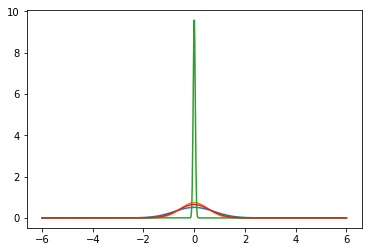

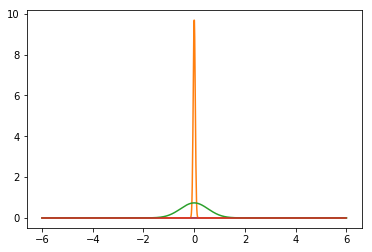

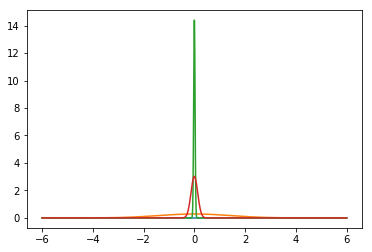

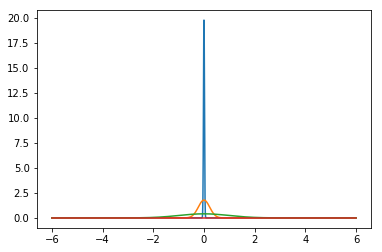

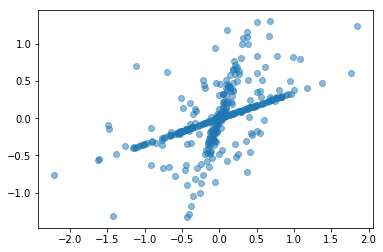

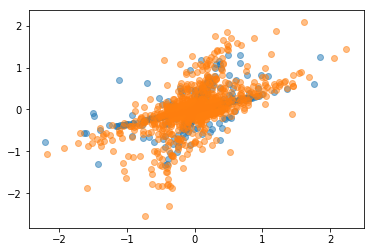

In [72]:
testinput = dict(ifa.variables)
testinput.pop('sources')

plot_source_distributions(generated['mixture_component_var'],sess)
plot_source_distributions(testinput['mixture_component_var'],sess)
plt.scatter(*generated['data'].T,alpha=.5)
plt.show()
plt.scatter(*generated['data'].T,alpha=.5)
plt.scatter(*sess.run(centeredIndependentFactorAnalysisTest(1000, 1, **testinput).distribution.sample()).T, alpha=.5)
plt.show()

In [51]:
predicted = sess.run(ifa.variables)

In [52]:
fgen = generated['factor_loadings']
fpred = predicted['factor_loadings']
fgen = 100*fgen/np.linalg.norm(fgen,axis=1,keepdims=True)
fpred = 100*fpred/np.linalg.norm(fpred,axis=1,keepdims=True)
fica_n = 100*fica/np.linalg.norm(fica, axis=1, keepdims=True)

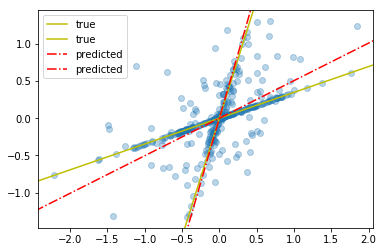

In [53]:
fig, ax = plt.subplots()
ax.scatter(*generated['data'].T,alpha=0.3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for fg in fgen:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='y',label='true')

for fg in fpred:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='r', linestyle='-.', label='predicted')

#for fg in fica_n:
#    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='k',linestyle='--',label='initial')

plt.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim);

#plt.plot((-1,1),(0,0),'k--')
#plt.plot((0,0),(-1,1),'k--')



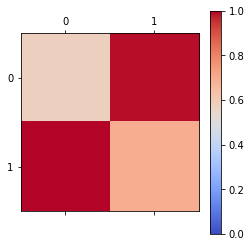

In [54]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],predicted['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [59]:
def plot_source_distributions(mixture_component_var,sess):
    n_sources,n_components_in_mixture = mixture_component_var.shape
    batch_event_space = np.stack((n_sources*n_components_in_mixture)*[np.linspace(-6,6,1000).astype(np.float32)],axis=1).reshape(-1,n_sources,n_components_in_mixture)
    densities = sess.run(tfd.Normal(loc=0.,scale=tf.sqrt(mixture_component_var)).prob(batch_event_space))
    for i in range(n_sources):
        plt.show()
        for j in range(n_components_in_mixture):
            plt.plot(batch_event_space[:,i,j],densities[:,i,j])
    plt.show()

In [60]:
generated['data'].var(0)

array([0.19457601, 0.12146057], dtype=float32)

In [61]:
generated['mixture_component_var']

array([[6.0803431e-01, 2.9040006e-01, 1.7019297e-03, 3.8112330e-01],
       [1.2272345e-06, 1.6616391e-03, 2.9370385e-01, 1.9973658e-11]],
      dtype=float32)

In [62]:
generated['mixture_component_var'].mean(1)

array([0.3203149 , 0.07384168], dtype=float32)

In [63]:
predicted['mixture_component_var']

array([[1.1120777e-07, 1.9374923e+00, 7.3203468e-04, 1.7442754e-02],
       [3.7043387e-04, 5.0092172e-02, 9.5376790e-01, 2.6732698e-07]],
      dtype=float32)

In [64]:
predicted['mixture_component_var'].mean(1)

array([0.48891678, 0.25105768], dtype=float32)

In [65]:
generated['data_var']

array([[1.3916445e-05, 5.8141513e-06]], dtype=float32)

In [66]:
predicted['data_var']

array([[0.03663244, 0.00738817]], dtype=float32)

In [67]:
generated['factor_loadings']

array([[ 1.0339919 ,  0.35855475],
       [-0.32143503, -1.0228226 ]], dtype=float32)

In [68]:
predicted['factor_loadings']

array([[-1.5967485, -5.525745 ],
       [ 7.1596036,  3.6114676]], dtype=float32)

In [69]:
generated['sources'].std(0)

array([0.4599351, 0.3372055], dtype=float32)

In [70]:
predicted['sources'].std(0)

array([0.31482115, 0.2701986 ], dtype=float32)